# Exploring Suburbs in Great Sydney
### Weiyi Wang

# Introduction

Sydney is the capital city of New South Wales (NSW) and home to over 60% percent of the state's popolation. The city is made of 658 suburbs and spreads over 33 local government areas. Sydney is ranked in the top ten most livable cities but also one of the most expensive cities in the world. It's the financial capital of Australia, and some of Australian top universities are also located in Sydeny. Sydney has attracted both domestic and oversea people to start a new life here.

The aim of this project is to explore top venues in boroughs of Sydney and help residents fresh off the boat find optimal residence locations and adjust to the new living environment. The target object includes both students and people who want to pursue their career in Sydney.

# Data

Second-level Administrative Divisions, Australia, 2015 (https://geo.nyu.edu/catalog/stanford-fc944xn1421)
The spatial data utilized in this project is imported from New York University's (NYU) Spatial Data Repository. The polygon shapefile contains second-level administrative divisions of Australia. Level 2 divisions include local government areas, including aboriginal councils, boroughs, cities, community government councils, district councils, municipailities, rural cities, shires and territories.

Then Foursquare location data was applied to exlore the top venues in each suburb. 

Importing libraries

In [261]:
import numpy as np
import pandas as pd

import json
from pandas.io.json import json_normalize

from geopy.geocoders import Nominatim

import requests

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

import matplotlib.pyplot as plt

print('Libraries imported')

Libraries imported


## Loading data.


In [52]:
json_file_path = 'stanford-fc944xn1421-geojson.json'

with open(json_file_path, 'r') as j:
     aussie_data = json.loads(j.read())

borough_data = aussie_data['features']

The GeoJSON file contains multipoint type data and pairs of coordinates. 
'name_1' refers to the State or Territory.
'name_2' refers to the borough or council.

In [53]:
#defining dataframe columns
column_names = ['State/Territory', 'Borough', 'Latitude', 'Longitude']
boroughs = pd.DataFrame(columns = column_names)
boroughs

,State/Territory,Borough,Latitude,Longitude


In [54]:
#itering the data and moving to the dataframe
for data in borough_data:
    state = borough = data['properties']['name_1']
    borough = data['properties']['name_2']
    
    borough_coordinates = data['geometry']['coordinates']
    borough_longitude = borough_coordinates[0][0][0][0] 
    borough_latitude = borough_coordinates[0][0][0][1]
    
    boroughs = boroughs.append({'State/Territory':state,
                               'Borough': borough,
                               'Longitude': borough_longitude,
                               'Latitude': borough_latitude}, ignore_index = True)

In [55]:
boroughs.head()

,State/Territory,Borough,Latitude,Longitude
0,Ashmore and Cartier Islands,n.a.1,-12.243176,123.135139
1,Australian Capital Territory,Acton,-35.298828,149.085983
2,Australian Capital Territory,Ainslie,-35.277584,149.142258
3,Australian Capital Territory,Amaroo,-35.169235,149.113922
4,Australian Capital Territory,Aranda,-35.258518,149.088074


In [56]:
print('The dataframe has {} states/territories and {} boroughs.'.format(
        len(boroughs['State/Territory'].unique()),
        boroughs.shape[0]
    )
)
boroughs['State/Territory'].value_counts()

The dataframe has 11 states/territories and 1395 boroughs.


Queensland                      475
Victoria                        208
New South Wales                 199
Western Australia               141
South Australia                 127
Australian Capital Territory    109
Northern Territory               95
Tasmania                         38
Ashmore and Cartier Islands       1
Jervis Bay Territory              1
Coral Sea Islands                 1
Name: State/Territory, dtype: int64

In [57]:
#retrieving NSW data
nsw = boroughs[boroughs['State/Territory'].str.contains('New South Wales')].reset_index(drop = True)
nsw.head()

,State/Territory,Borough,Latitude,Longitude
0,New South Wales,Hawkesbury,-33.416920,150.508408
1,New South Wales,Hay,-34.248920,144.222931
2,New South Wales,Albury,-35.914963,146.971710
3,New South Wales,Armidale Dumaresq Bal,-30.589890,151.632751
4,New South Wales,Armidale Dumaresq,-30.483726,151.661728


In [58]:
nsw.shape

(199, 4)

In this dataset, there are 199 boroughs in NSW. To further retrieve Sydney data, according to Google Map, Sydney's corrdinates are -33.865143, 151.209900. Firstly, selecting data in the range[(-35,-33),(150,152)], then manually drop the boroughs that are not within 50km radius of Sydney and duplicates such as Bankstown-South, Bankstown-North-East and Bankstown-North_West.

In [59]:
sydney = nsw[(nsw['Latitude']>-35) & (nsw['Latitude']<-33)].reset_index(drop = True)
sydney = sydney[(sydney['Longitude']>150) & (sydney['Longitude']<152)].reset_index(drop = True)

sydney

,State/Territory,Borough,Latitude,Longitude
0,New South Wales,Hawkesbury,-33.416920,150.508408
1,New South Wales,Ashfield,-33.870983,151.119431
2,New South Wales,Auburn,-33.850048,151.081467
3,New South Wales,Bankstown - North-East,-33.934044,151.038269
4,New South Wales,Bankstown - North-West,-33.929268,150.978989
...,...,...,...,...
71,New South Wales,Wollongong - Inner,-34.428276,150.903976
72,New South Wales,Wollongong Bal,-34.542221,150.873337
73,New South Wales,Woollahra,-33.889961,151.240784
74,New South Wales,Wyong - North-East,-33.276604,151.491043


In [60]:
sydney = sydney.drop([0,4,5,7,8,9,11,13,14,16,17,18,21,24,25,26,29,31,34,35,39,41,42,48,52,53,55,56,57,58,60,62,65,66,69,70,71,72,74,75]).reset_index(drop = True)
sydney.shape

(36, 4)

For further explorations, the dataframe is stored as .csv file.

In [39]:
sydney.to_csv('sydney.csv')

# Methdology

## Mapping the distribution of borough in Sydney.

In [62]:
address = 'Sydney, New South Wales'

geolocator = Nominatim(user_agent="nsw_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney are -33.8548157, 151.2164539.


In [100]:
df = pd.read_csv('sydney.csv')

In [101]:
# create map of Toronto using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for borough, lat, lng in zip(df['Neighborhood'],df['Latitude'], df['Longitude']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)  
    
map_sydney

## Define Foursquare Credentials and Version

In [50]:
CLIENT_ID = 'MM0EVQ32KORHJ5VSJGZKOJWCCSN3BAD4P4KMKLUTG1HREYT4' # your Foursquare ID
CLIENT_SECRET = 'YW0FYEQVW3DTNYMEHRMFOGYKO5GV0C24NLEMXZZ5HTBHZ1KZ' # your Foursquare Secret
VERSION = '20180605'

## Exploring the First Borough

In [102]:
df.loc[0, 'Neighborhood']

neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Ashfield are -33.87098312, 151.1194305.


### Now, let's get the top 10 venues that are in Ashfield within a radius of 500 meters.

In [103]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=MM0EVQ32KORHJ5VSJGZKOJWCCSN3BAD4P4KMKLUTG1HREYT4&client_secret=YW0FYEQVW3DTNYMEHRMFOGYKO5GV0C24NLEMXZZ5HTBHZ1KZ&v=20180605&ll=-33.87098312,151.1194305&radius=500&limit=100'

In [104]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60d19df3a50fc23e5a5a431d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Croydon',
  'headerFullLocation': 'Croydon, Sydney',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 9,
  'suggestedBounds': {'ne': {'lat': -33.866483115499996,
    'lng': 151.12484014886846},
   'sw': {'lat': -33.8754831245, 'lng': 151.11402085113153}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '562ff981498e847173f20ccf',
       'name': 'Akasha Brewing',
       'location': {'address': '10A Spencer St',
        'lat': -33.86960796613614,
        'lng': 151.11823308857333,
        'labeledLatLngs': [{'label': 'display',
          'lat': -33.869607966

In [105]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [106]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Akasha Brewing,Brewery,-33.869608,151.118233
1,Pasticceria Papa,Bakery,-33.868956,151.117346
2,Fitness First,Gym,-33.869879,151.122429
3,Five Dock Leisure Centre,Gym,-33.868451,151.118053
4,Wagyu House,Korean BBQ Restaurant,-33.871599,151.122782


In [107]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

9 venues were returned by Foursquare.


## Explore Neighborhoods in Sydney

In [108]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [109]:
Sydney_venues = getNearbyVenues(df['Neighborhood'], df['Latitude'], df['Longitude'])
print(Sydney_venues.shape)
Sydney_venues.head()

Ashfield
Auburn
Bankstown
Baulkham Hills
Blacktown
Botany Bay
Burwood
Canada Bay
Canterbury
Fairfield
Holroyd
Hornsby
Hunters Hill
Hurstville
Kogarah
Ku-ring-gai
Lane Cove
Leichhardt
Liverpool
Manly
Marrickville
Mosman
North Sydney
Parramatta
Pittwater
Randwick
Rockdale
Ryde
Strathfield
Sutherland Shire
Sydney
Warringah
Waverley
Willoughby
Woollahra
(331, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ashfield,-33.870983,151.11943,Akasha Brewing,-33.869608,151.118233,Brewery
1,Ashfield,-33.870983,151.11943,Pasticceria Papa,-33.868956,151.117346,Bakery
2,Ashfield,-33.870983,151.11943,Fitness First,-33.869879,151.122429,Gym
3,Ashfield,-33.870983,151.11943,Five Dock Leisure Centre,-33.868451,151.118053,Gym
4,Ashfield,-33.870983,151.11943,Wagyu House,-33.871599,151.122782,Korean BBQ Restaurant


In [110]:
Sydney_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ashfield,9,9,9,9,9,9
Auburn,7,7,7,7,7,7
Bankstown,4,4,4,4,4,4
Blacktown,4,4,4,4,4,4
Burwood,35,35,35,35,35,35
Canada Bay,6,6,6,6,6,6
Canterbury,27,27,27,27,27,27
Fairfield,7,7,7,7,7,7
Holroyd,4,4,4,4,4,4


In [78]:
print('There are {} uniques categories.'.format(len(Sydney_venues['Venue Category'].unique())))

There are 103 uniques categories.


## Analyze Each Neighborhood

In [111]:
# one hot encoding
Sydney_onehot = pd.get_dummies(Sydney_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Sydney_onehot['Neighborhood'] = Sydney_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Sydney_onehot.columns[-1]] + list(Sydney_onehot.columns[:-1])
Sydney_onehot = Sydney_onehot[fixed_columns]

Sydney_onehot.head()

,Neighborhood,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beach,Board Shop,...,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Track,Trail,Train Station,Tunnel,Vietnamese Restaurant,Whisky Bar
0,Ashfield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ashfield,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ashfield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ashfield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ashfield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
Sydney_onehot.shape

(331, 104)

In [113]:
Sydney_grouped = Sydney_onehot.groupby('Neighborhood').mean().reset_index()
Sydney_grouped

,Neighborhood,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beach,Board Shop,...,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Track,Trail,Train Station,Tunnel,Vietnamese Restaurant,Whisky Bar
0,Ashfield,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,Auburn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.142857,0.000000,0.000000,0.000000
2,Bankstown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,Blacktown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Burwood,0.000000,0.000000,0.000000,0.000000,0.000000,0.085714,0.000000,0.000000,0.00,...,0.000000,0.057143,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.057143,0.000000
5,Canada Bay,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,Canterbury,0.000000,0.000000,0.000000,0.037037,0.000000,0.037037,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.074074,0.000000,0.000000,0.000000
7,Fairfield,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,Holroyd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,...,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000
9,Hunters Hill,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [114]:
Sydney_grouped.shape

(29, 104)

### Top 5 most common venues for each neighborhood


In [440]:
num_top_venues = 5

for hood in Sydney_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Sydney_grouped[Sydney_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ashfield----
                   venue  freq
0   Fast Food Restaurant  0.22
1                    Gym  0.22
2  Korean BBQ Restaurant  0.11
3                 Bakery  0.11
4             Playground  0.11


----Auburn----
             venue  freq
0         Platform  0.29
1  Paintball Field  0.14
2             Lake  0.14
3             Park  0.14
4              Pub  0.14


----Bankstown----
                           venue  freq
0  Paper / Office Supplies Store  0.50
1            Rental Car Location  0.25
2                      Pet Store  0.25
3           Pakistani Restaurant  0.00
4                           Pool  0.00


----Blacktown----
                           venue  freq
0                   Intersection  0.50
1                   Liquor Store  0.25
2                      Hotel Bar  0.25
3         Argentinian Restaurant  0.00
4  Paper / Office Supplies Store  0.00


----Burwood----
                   venue  freq
0  Korean BBQ Restaurant  0.14
1      Korean Restaurant  0.11
2          

In [418]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [474]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Sydney_grouped['Neighborhood']

for ind in np.arange(Sydney_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Sydney_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ashfield,Fast Food Restaurant,Gym,Brewery,Bakery,Souvlaki Shop
1,Auburn,Platform,Pub,Train Station,Lake,Park
2,Bankstown,Paper / Office Supplies Store,Rental Car Location,Pet Store,Whisky Bar,Gastropub
3,Blacktown,Intersection,Hotel Bar,Liquor Store,Greek Restaurant,Farmers Market
4,Burwood,Korean BBQ Restaurant,Korean Restaurant,Café,Bakery,Vietnamese Restaurant


## Cluster Neighborhoods

In [475]:
# set number of clusters
kclusters = 5

Sydney_grouped_clustering = Sydney_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Sydney_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 0, 3, 3, 3, 3, 3, 4, 1], dtype=int32)

In [476]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Sydney_merged = df

# add latitude/longitude for each neighborhood
Sydney_merged = Sydney_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Sydney_merged = Sydney_merged.dropna()

Sydney_merged.head() # check the last columns!

,Unnamed: 0,State/Territory,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,New South Wales,Ashfield,-33.870983,151.119430,3.0,Fast Food Restaurant,Gym,Brewery,Bakery,Souvlaki Shop
1,1,New South Wales,Auburn,-33.850048,151.081467,3.0,Platform,Pub,Train Station,Lake,Park
2,2,New South Wales,Bankstown,-33.934044,151.038269,0.0,Paper / Office Supplies Store,Rental Car Location,Pet Store,Whisky Bar,Gastropub
4,6,New South Wales,Blacktown,-33.741291,150.865662,3.0,Intersection,Hotel Bar,Liquor Store,Greek Restaurant,Farmers Market
6,3,New South Wales,Burwood,-33.871883,151.094498,3.0,Korean BBQ Restaurant,Korean Restaurant,Café,Bakery,Vietnamese Restaurant


## Examine Clusters

In [501]:
cluster0 = Sydney_merged_nonan.loc[Sydney_merged_nonan['Cluster Labels'] == 0, Sydney_merged_nonan.columns[[2] + list(range(5, Sydney_merged_nonan.shape[1]))]]
cluster0

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Top Venues,Label
16,Bankstown,0.0,Paper / Office Supplies Store,Rental Car Location,Pet Store,Whisky Bar,Gastropub,"2 Paper / Office Supplies Store, 1 Pet Store",Office Supplies


In [507]:
venues0 = cluster0['1st Most Common Venue'].append(
    cluster0['2nd Most Common Venue']).append(
    cluster0['3rd Most Common Venue']).append(
    cluster0['4th Most Common Venue']).append(
    cluster0['5th Most Common Venue'])

print(venues0.value_counts())

Pet Store                        1
Gastropub                        1
Whisky Bar                       1
Rental Car Location              1
Paper / Office Supplies Store    1
dtype: int64


In [508]:
cluster1 = Sydney_merged_nonan.loc[Sydney_merged_nonan['Cluster Labels'] == 1, Sydney_merged_nonan.columns[[2] + list(range(5, Sydney_merged_nonan.shape[1]))]]
cluster1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Top Venues,Label
21,Hunters Hill,1.0,Café,Scenic Lookout,Whisky Bar,German Restaurant,Farmers Market,"1 Café, 1 Scenic Lookout",Café and Beach
22,Ku-ring-gai,1.0,Beach,Park,Harbor / Marina,Café,Whisky Bar,"1 Beach, 1 Café",Café and Beach
23,Lane Cove,1.0,Café,Coffee Shop,Chinese Restaurant,Pub,Supermarket,"19 Café, 5 Coffee Shop",Café and Beach
24,Parramatta,1.0,Café,Rugby Pitch,Hookah Bar,Gym / Fitness Center,Whisky Bar,"2 Café, 1 Gym / Fitness Center",Café and Beach
25,Sydney,1.0,Café,Pub,Coffee Shop,Bar,Lebanese Restaurant,"13 Café, 7 Pub",Café and Beach
26,Warringah,1.0,Beach,Park,Harbor / Marina,Café,Whisky Bar,"1 Beach, 1 Café",Café and Beach
27,Woollahra,1.0,Café,Pub,Japanese Restaurant,Gastropub,Fried Chicken Joint,"4 Café, 2 Pub",Café and Beach


In [509]:
venues1 = cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue'])

print(venues1.value_counts())

Café                    7
Whisky Bar              4
Pub                     3
Beach                   2
Harbor / Marina         2
Coffee Shop             2
Park                    2
Supermarket             1
Rugby Pitch             1
Fried Chicken Joint     1
Bar                     1
German Restaurant       1
Japanese Restaurant     1
Lebanese Restaurant     1
Farmers Market          1
Gastropub               1
Scenic Lookout          1
Hookah Bar              1
Gym / Fitness Center    1
Chinese Restaurant      1
dtype: int64


In [510]:
cluster2 = Sydney_merged_nonan.loc[Sydney_merged_nonan['Cluster Labels'] == 2, Sydney_merged_nonan.columns[[2] + list(range(5, Sydney_merged_nonan.shape[1]))]]
cluster2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Top Venues,Label
28,Pittwater,2.0,Hotel,Whisky Bar,Greek Restaurant,Farmers Market,Fast Food Restaurant,1 Hotel,Hotel


In [511]:
venues2 = cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue'])

print(venues2.value_counts())

Greek Restaurant        1
Hotel                   1
Whisky Bar              1
Fast Food Restaurant    1
Farmers Market          1
dtype: int64


In [513]:
cluster3 = Sydney_merged_nonan.loc[Sydney_merged_nonan['Cluster Labels'] == 3, Sydney_merged_nonan.columns[[2] + list(range(5, Sydney_merged_nonan.shape[1]))]]
cluster3

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Top Venues,Label
0,Ashfield,3.0,Fast Food Restaurant,Gym,Brewery,Bakery,Souvlaki Shop,"2 Fast Food Restaurant, 2 Gym","Food, Drink and Entertainment"
1,Auburn,3.0,Platform,Pub,Train Station,Lake,Park,"2 Platform, 1 Lake","Food, Drink and Entertainment"
2,Blacktown,3.0,Intersection,Hotel Bar,Liquor Store,Greek Restaurant,Farmers Market,"2 Intersection, 1 Hotel Bar","Food, Drink and Entertainment"
3,Burwood,3.0,Korean BBQ Restaurant,Korean Restaurant,Café,Bakery,Vietnamese Restaurant,"5 Korean BBQ Restaurant, 4 Korean Restaurant","Food, Drink and Entertainment"
4,Canada Bay,3.0,Playground,Convenience Store,Football Stadium,Pharmacy,Liquor Store,"1 Convenience Store, 1 Football Stadium","Food, Drink and Entertainment"
5,Canterbury,3.0,Platform,Bubble Tea Shop,Chinese Restaurant,Coffee Shop,Park,"4 Platform, 2 Bubble Tea Shop","Food, Drink and Entertainment"
6,Fairfield,3.0,Gym,Fast Food Restaurant,Food Truck,Clothing Store,Liquor Store,"1 Clothing Store, 1 Fast Food Restaurant","Food, Drink and Entertainment"
7,Hurstville,3.0,Pub,Train Station,Chinese Restaurant,Theater,Thai Restaurant,"1 Chinese Restaurant, 1 Pub","Food, Drink and Entertainment"
8,Kogarah,3.0,Chinese Restaurant,Park,Gym,Greek Restaurant,Sports Club,"1 Chinese Restaurant, 1 Greek Restaurant","Food, Drink and Entertainment"
9,Leichhardt,3.0,Pier,Café,Tunnel,Art Gallery,Boat or Ferry,"2 Café, 2 Pier","Food, Drink and Entertainment"


In [514]:
venues3 = cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue'])

print(venues3.value_counts())

Park                     7
Chinese Restaurant       5
Pub                      4
Platform                 3
Gym                      3
Coffee Shop              3
Liquor Store             3
Train Station            3
Whisky Bar               2
Thai Restaurant          2
Theater                  2
Beach                    2
Sports Club              2
Bubble Tea Shop          2
Café                     2
Playground               2
Fast Food Restaurant     2
Bakery                   2
Greek Restaurant         2
Pier                     2
Farmers Market           1
Gastropub                1
Korean Restaurant        1
Vietnamese Restaurant    1
Bowling Green            1
Cemetery                 1
Lake                     1
Football Stadium         1
Trail                    1
Restaurant               1
Brewery                  1
Boat or Ferry            1
Intersection             1
Food Truck               1
Hotel Bar                1
Plaza                    1
Tunnel                   1
S

In [515]:
cluster4 = Sydney_merged_nonan.loc[Sydney_merged_nonan['Cluster Labels'] == 4, Sydney_merged_nonan.columns[[2] + list(range(5, Sydney_merged_nonan.shape[1]))]]
cluster4

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Top Venues,Label
17,Holroyd,4.0,Park,Track,Board Shop,Whisky Bar,German Restaurant,"2 Park, 1 Board Shop",Park and Landscaping
18,Mosman,4.0,Park,Playground,Whisky Bar,Intersection,Farmers Market,"2 Park, 1 Playground",Park and Landscaping
19,Ryde,4.0,Construction & Landscaping,Park,Boat Launch,Whisky Bar,Greek Restaurant,"1 Boat Launch, 1 Construction & Landscaping",Park and Landscaping
20,Willoughby,4.0,Park,Harbor / Marina,Boat Launch,Whisky Bar,Greek Restaurant,"2 Park, 1 Boat Launch",Park and Landscaping


In [516]:
venues4 = cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue'])

print(venues4.value_counts())

Park                          4
Whisky Bar                    4
Boat Launch                   2
Greek Restaurant              2
Farmers Market                1
Track                         1
Construction & Landscaping    1
Intersection                  1
Harbor / Marina               1
German Restaurant             1
Board Shop                    1
Playground                    1
dtype: int64


### Exploring More into Top Venues

In [496]:
cluster_venue = top_venues.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Count')
# change NaN values to 0
cluster_venue = cluster_venue.fillna(0).astype(int).reset_index(drop=True)
cluster_venue

1st Most Common Venue,Beach,Café,Chinese Restaurant,Construction & Landscaping,Fast Food Restaurant,Gym,Hotel,Intersection,Korean BBQ Restaurant,Paper / Office Supplies Store,Park,Pier,Platform,Playground,Pub
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,0,1,0,1,1,0,1,1,0,2,1,3,1,3
4,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

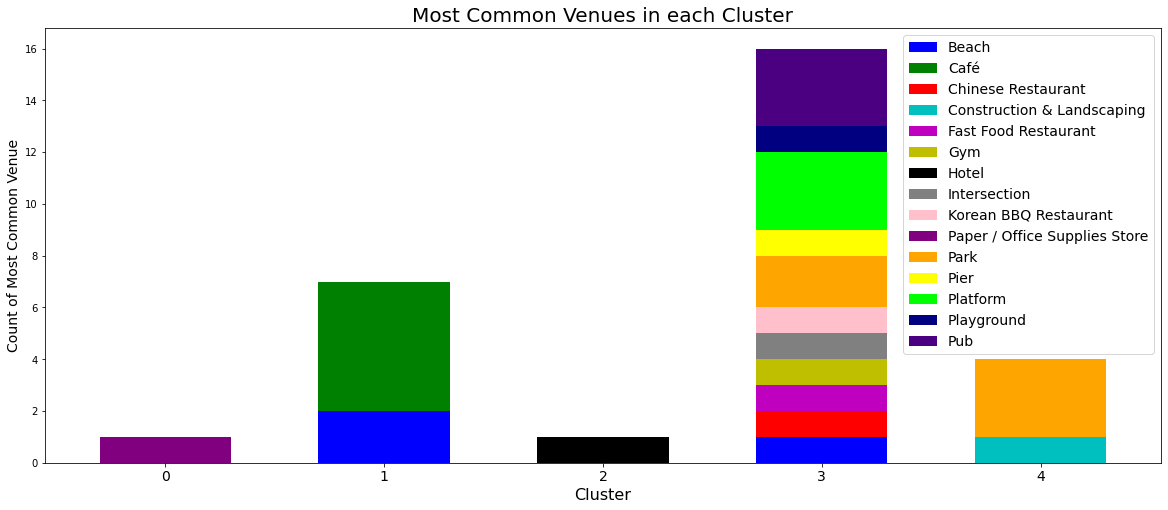

In [497]:
# Create a bar chart of most common venues of each cluster
my_colors = ['b','g','r','c','m','y','k','gray','pink','purple','orange','yellow','lime','navy','indigo']
cv_plot = cluster_venue.plot(kind='bar', stacked=True,
                            figsize=(20,8), color=my_colors,
                            width=0.6)
plt.title("Most Common Venues in each Cluster", fontsize=20)
plt.xlabel("Cluster", fontsize=16)
plt.ylabel("Count of Most Common Venue", fontsize=14)
plt.legend(labels=cluster_venue.columns, fontsize=14)
plt.xticks(rotation=0, fontsize=14)

In [517]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

Sydney_merged_nonan = new_merged.dropna(subset=['Cluster Labels'])

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Sydney_merged_nonan['Latitude'], Sydney_merged_nonan['Longitude'], Sydney_merged_nonan['Neighborhood'], Sydney_merged_nonan['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results and Discussion

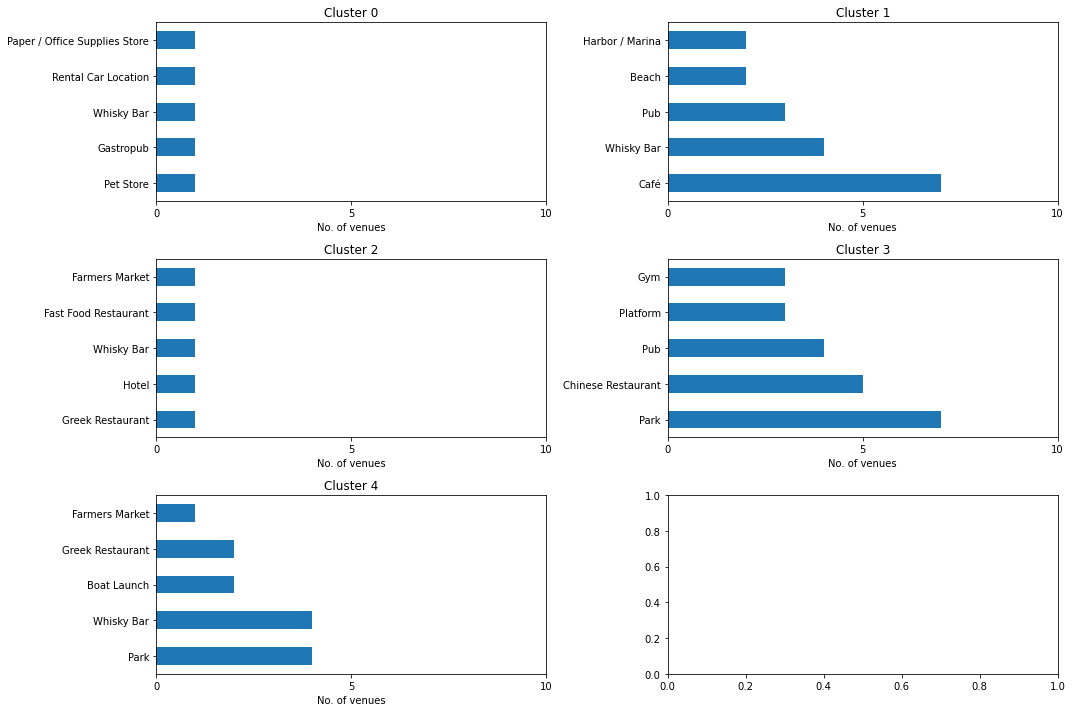

In [521]:
df_list = [ venues0, venues1 ,venues2, venues3, venues4]
fig, axes = plt.subplots(3, 2)

count = 0
for r in range(3):
    for c in range(2):
        if r != 2 or c != 1:
            df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
            axes[r,c].set_title('Cluster {}'.format(count))
            plt.sca(axes[r, c])
            plt.xticks(np.arange(0, 15, 5))
            plt.xlabel('No. of venues')
            count += 1

fig.tight_layout()

According to top venues in each suburb of Great Sydney, the neighborhoods are divided into 5 clusters.
Cluster 0 has more number of office supplies, car rental, bars and pet stores.
Cluster 1 has more number of harbors, beaches, pubs, bars and cafés.
Cluster 2 has more number of farmers market, restaurants and bars.
Cluster 3 has more number of gyms, platforms, pubs, restaurants and parks.
Cluster 4 has more number of farmers market, restaurants, boatings, bars and parks.

# Conclusion

If a person is an office supply and pet lover, willing to drive around, it will be nice to live in Bankstown.
If a person is interested in seas and drinks, living in neighborhoods like Hunters Hill, Parramata and Sydney etc. will be ideal.
If a person is a food and drink lover, Pittwater is a good choice.
If a person is sporty and likes to hang out, it is a good choice to live in Ashfiels, Canada Bay and Blacktown etc.
If a person is a food lover but also loves boating, Holroyd, Mosman and Ryde etc. are on top of the list.